# Portfolio Workflow

## Use the last week to determine current portfolio mix

In [1]:
from platform import python_version
import configparser
import logging.config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
import trading_factors_yahoo as alpha_factors
import ameritrade_functions as amc
import utils as utils

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('JointHoldingsAdjustement')
logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['JOINT']

# Which account are we interested in
masked_account_number = default_config['masked_account_number']
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = '../data/price_histories_yahoo.csv'

2022-12-04 23:55:45,405|JointHoldingsAdjustement|INFO|Python version: 3.8.15
2022-12-04 23:55:45,405|JointHoldingsAdjustement|INFO|Pandas version: 1.5.2


In [2]:
price_histories_file_name = default_config["DataDirectory"] + '/' + default_config["PriceHistoriesFileName"]
logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
logger.info(f'PRICE_HISTORIES|{price_histories.index.min()}|{price_histories.index.max()}')
returns = alpha_factors.FactorReturns(price_histories).factor_data

ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
logger.info(f'AI_ALPHA_FACTORS_FILE|{ai_alpha_factors_file_name}')

beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config["BetaFactorsFileName"]
logger.info(f'BETA_FACTORS_FILE|{beta_factors_file_name}')

alpha_vectors = pd.read_csv(ai_alpha_factors_file_name, parse_dates=['Date']).set_index(['Date']).sort_index()
logger.info(f'ALPHA_STOCKS|{len(alpha_vectors.columns)}')

2022-12-04 23:55:45,441|JointHoldingsAdjustement|INFO|PRICE_HISTORIES_FILE|./data/price_histories_yahoo.csv...
2022-12-04 23:55:46,565|JointHoldingsAdjustement|INFO|PRICE_HISTORIES|2017-12-04 00:00:00|2022-12-02 00:00:00
2022-12-04 23:55:46,600|JointHoldingsAdjustement|INFO|AI_ALPHA_FACTORS_FILE|./data/alpha_vectors.csv
2022-12-04 23:55:46,601|JointHoldingsAdjustement|INFO|BETA_FACTORS_FILE|./data/daily_beta.pickle
2022-12-04 23:55:46,810|JointHoldingsAdjustement|INFO|ALPHA_STOCKS|501


In [3]:
risk_cap = float(default_config['risk_cap'])
weights_max = float(default_config['weights_max'])
weights_min = float(default_config['weights_min'])
logger.info(f'OPTIMIZATION|risk_cap|{risk_cap}')
logger.info(f'OPTIMIZATION|weights_max|{weights_max}')
logger.info(f'OPTIMIZATION|weights_min|{weights_min}')

2022-12-04 23:55:46,831|JointHoldingsAdjustement|INFO|OPTIMIZATION|risk_cap|0.015
2022-12-04 23:55:46,835|JointHoldingsAdjustement|INFO|OPTIMIZATION|weights_max|0.2
2022-12-04 23:55:46,836|JointHoldingsAdjustement|INFO|OPTIMIZATION|weights_min|0.0


In [4]:
reduced_stocks = utils.reduce_universe_by_sentiment(alpha_vectors.columns)

Tickers:   0%|          | 0/501 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/501 [00:00<?, ?News Table Items/s]

c:\users\hp-z440\anaconda projects\svi-trading-tools\tools\utils.py:338: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = parsed_and_scored_news.groupby(['ticker', 'date']).mean().fillna(0)


In [5]:
# Error check to make sure we didn't reduce by too much

pct_red = len(reduced_stocks) / len(alpha_vectors.columns)
logger.info(f'SENTIMENT_REDUCTION|{pct_red:0.2f}|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
if pct_red < 0.50:
    logger.error(f'SENTIMENT_REDUCTION|OVER_REDUCED|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
    raise SystemExit

2022-12-04 23:59:21,480|JointHoldingsAdjustement|INFO|SENTIMENT_REDUCTION|0.85|501->428


In [6]:
final_alhpa_vectors = alpha_vectors[reduced_stocks]
logger.info(f'FINAL_ALPHA_STOCKS|{len(final_alhpa_vectors.columns)}')
opt_date = final_alhpa_vectors.index[-1]
start_of_returns = opt_date - pd.offsets.DateOffset(years=1)
final_beta_returns = returns[reduced_stocks].loc[start_of_returns:opt_date]
risk_model = alpha_factors.RiskModelPCA(final_beta_returns, 1, 20)
logger.info(f'OPT_DATE|{opt_date}')
alpha_vector = pd.DataFrame(final_alhpa_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

2022-12-04 23:59:21,518|JointHoldingsAdjustement|INFO|FINAL_ALPHA_STOCKS|428
2022-12-04 23:59:21,593|JointHoldingsAdjustement|INFO|OPT_DATE|2022-12-02 00:00:00


C:\Users\HP-Z440\anaconda3\envs\svi_tt_p308\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


2022-12-04 23:59:36,932|JointHoldingsAdjustement|INFO|AJD_PORT_VARIANCE|0.01500000


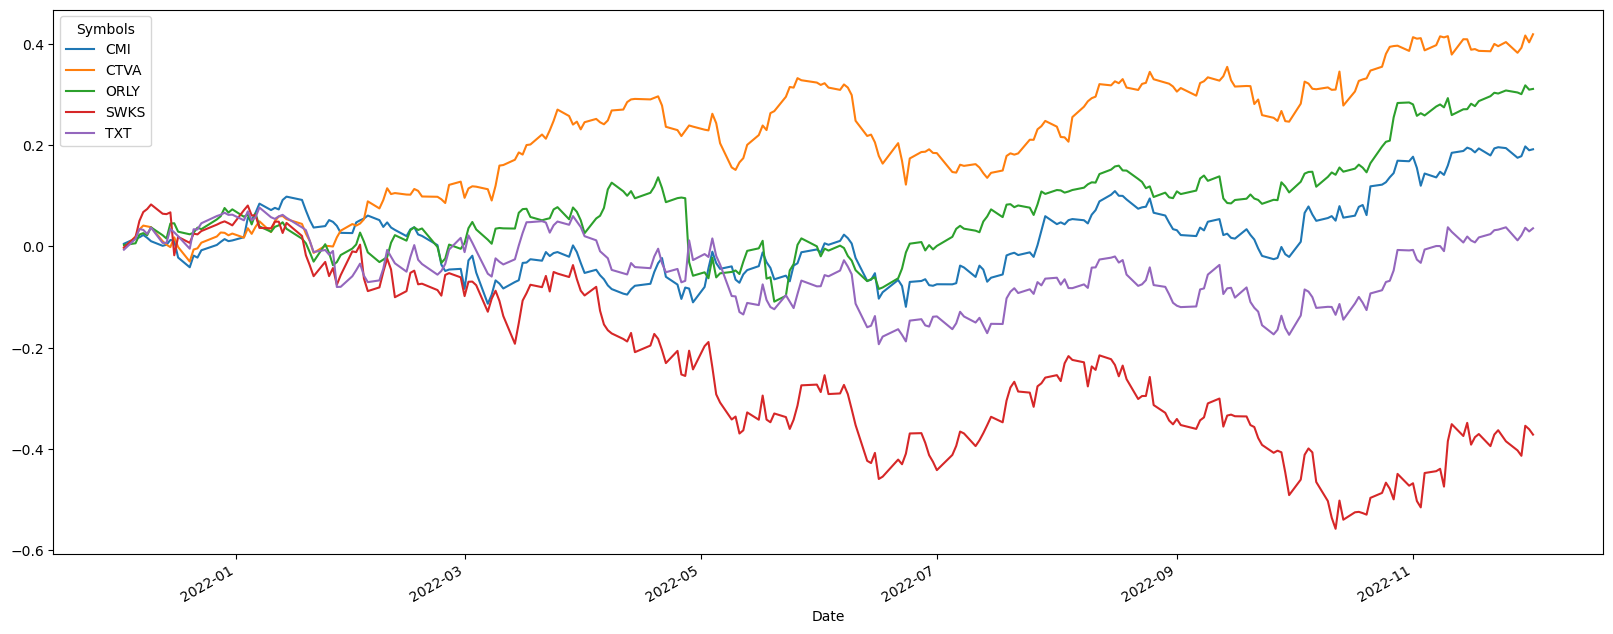

In [7]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 5.0]
returns[-252:][long_weights.index.to_list()].cumsum().plot(figsize=(20,8))
logger.info(f'AJD_PORT_VARIANCE|{risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [8]:
for index, row in long_weights.iterrows():
    logger.info(f'STOCK|{index:20}|HOLDING|{row.optimalWeights:2f}')

2022-12-04 23:59:37,293|JointHoldingsAdjustement|INFO|STOCK|CMI                 |HOLDING|0.200000
2022-12-04 23:59:37,293|JointHoldingsAdjustement|INFO|STOCK|CTVA                |HOLDING|0.200000
2022-12-04 23:59:37,294|JointHoldingsAdjustement|INFO|STOCK|ORLY                |HOLDING|0.200000
2022-12-04 23:59:37,296|JointHoldingsAdjustement|INFO|STOCK|SWKS                |HOLDING|0.195316
2022-12-04 23:59:37,296|JointHoldingsAdjustement|INFO|STOCK|TXT                 |HOLDING|0.143760


In [9]:
td_ameritrade = amc.AmeritradeRest()
display(td_ameritrade.get_fundamental(list(long_weights.index.to_list())))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,883203101,TXT,Textron Inc. Common Stock,NYSE,EQUITY,79.450,57.110,0.08,0.11,2022-12-08 00:00:00.000,...,8.78702,0.0,0.0,0.0,0.02,2023-01-01 00:00:00.000,1.51071,1041570.0,1041571.0,27385190.0
1,22052L104,CTVA,"Corteva, Inc. Common Stock",NYSE,EQUITY,68.430,43.740,0.60,0.89,2022-11-10 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.15,2022-12-15 00:00:00.000,0.74259,2348250.0,2348246.0,69944340.0
2,67103H107,ORLY,"O'Reilly Automotive, Inc. - Common Stock",NASDAQ,EQUITY,870.920,562.900,0.00,0.00,,...,0.00000,0.0,0.0,0.0,0.00,,0.96509,394330.0,394332.0,10264260.0
3,83088M102,SWKS,"Skyworks Solutions, Inc. - Common Stock",NASDAQ,EQUITY,164.470,76.160,2.48,2.64,2022-11-21 00:00:00.000,...,8.98323,0.0,0.0,0.0,0.62,2022-12-13 00:00:00.000,1.21128,1770670.0,1770666.0,43414900.0
4,231021106,CMI,Cummins Inc. Common Stock,NYSE,EQUITY,254.085,184.275,6.28,2.51,2022-11-17 00:00:00.000,...,7.78675,0.0,0.0,0.0,1.57,2022-12-01 00:00:00.000,1.05245,919450.0,919449.0,19710120.0


Tickers:   0%|          | 0/5 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/5 [00:00<?, ?News Table Items/s]

C:\Users\HP-Z440\AppData\Local\Temp\ipykernel_15448\1254735451.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()


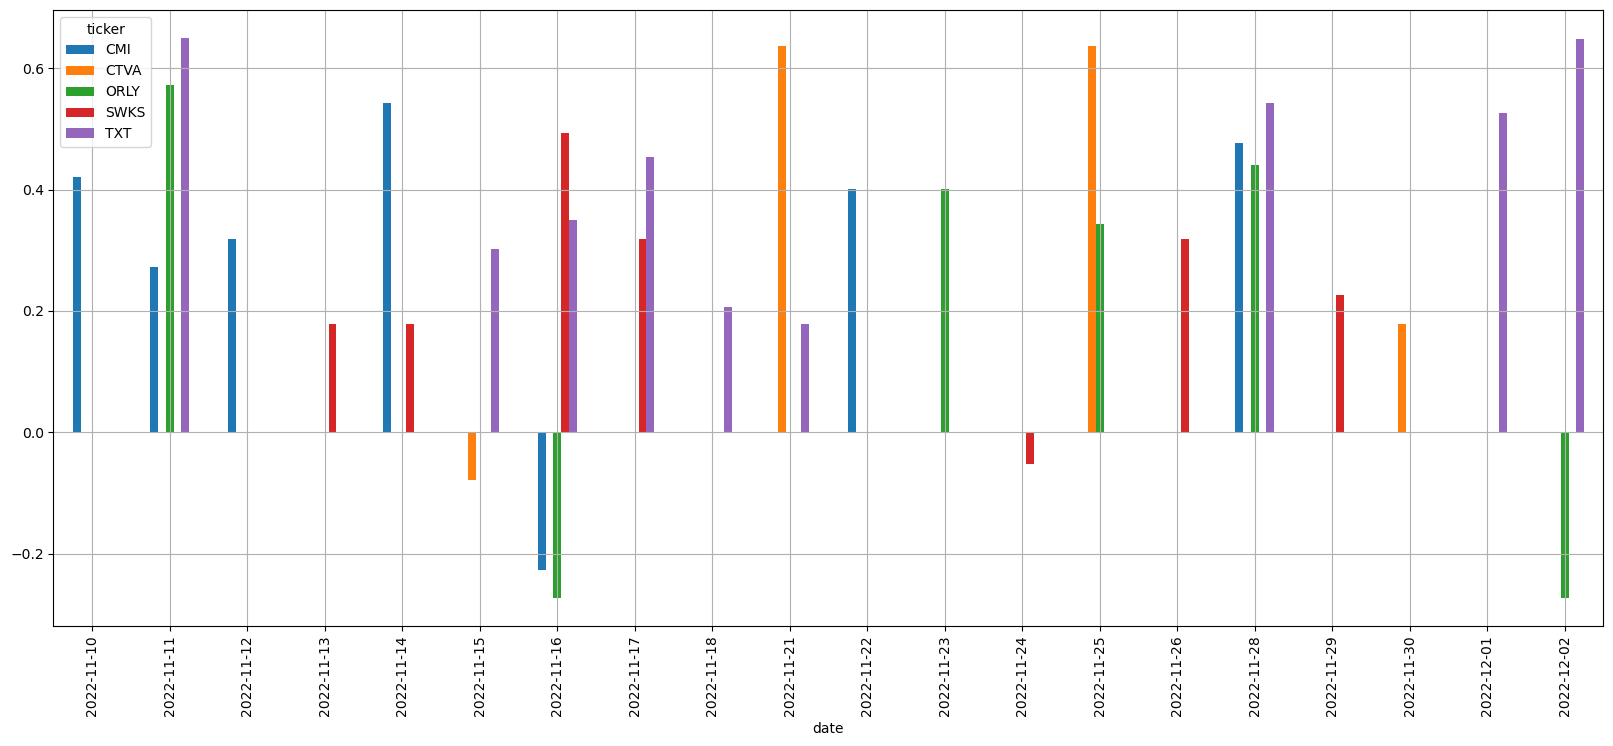

In [10]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

## First lets see which stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but I have not coded it yet.) You only need to do this if you
are going to use an existing Ameritrade account to define an initial set of stocks to analyze.

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

For security reasons, I sugges using environment variables to store your credential information. If you store them in property files, or just code them into your notebook, you risk sharing the information with others if you use GitHub or some other SCCS. This also makes it easier to have them availabe from project to project in your development environment

<span style="color:blue">Note: *Account numbers are masked for security purposes.*</span>

In [11]:
logger.info(f'TRADE_DATE|{datetime.today()}')

# Specific Portfolio Account
equity_investments_df = td_ameritrade.get_account_portfolio_data(masked_account_number, investment_type='EQUITY')
logger.info('Full Equity Portfolio:')
display(equity_investments_df)

2022-12-04 23:59:39,957|JointHoldingsAdjustement|INFO|TRADE_DATE|2022-12-04 23:59:39.957201
2022-12-04 23:59:40,204|JointHoldingsAdjustement|INFO|Full Equity Portfolio:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---2021 GRMN              0.0      90.45857             0.0   
         STZ               0.0     257.85143             0.0   
         WKHS              0.0      10.49180             0.0   
         UAL               0.0      43.79000             0.0   
         EEENF             0.0       0.04980             0.0   
         LDOS              0.0     108.36000             0.0   
         OKE               0.0      64.07000             0.0   
         WTW               0.0     243.50000             0.0   
         FGPHF             0.0       0.10927             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---2021 GRMN                     0.0                             0.0   
         STZ                      0.0                             0.0   
         WKHS                     0.0                             0.0   
         UAL                      0.0                             0.0   
         EEENF                    0.0                             0.0   
         LDOS                     0.0                             0.0   
         OKE                      0.0                             0.0   
         WTW                      0.0                             0.0   
         FGPHF                    0.0                             0.0   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---2021 GRMN            21.0                 21.0                   0.0   
         STZ              7.0                  7.0                   0.0   
         WKHS           300.0                300.0                   0.0   
         UAL             32.0                 32.0                   0.0   
         EEENF          250.0                250.0                   0.0   
         LDOS             5.0                  5.0                   0.0   
         OKE             30.0                 30.0                   0.0   
         WTW              8.0                  8.0                   0.0   
         FGPHF        25000.0              25000.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---2021 GRMN        1980.72                  594.22   
         STZ         1827.35                  548.21   
         WKHS         726.00                  600.00   
         UAL         1404.48                  421.34   
         EEENF          1.55                    0.00   
         LDOS         552.45                  165.74   
         OKE         2016.00                  806.40   
         WTW         1980.48                  594.14   
         FGPHF       1950.00                    0.00   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---2021 GRMN                           21.0    EQUITY  H2906T109           0   
         STZ                             7.0    EQUITY  21036P108           0   
         WKHS                          300.0    EQUITY  98138J206           0   
         UAL                            32.0    EQUITY  910047109           0   
         EEENF                         250.0    EQUITY  Q3394D101           0   
         LDOS                            5.0    EQUITY  525327102           0   
         OKE                            30.0    EQUITY  682680103           0   
         WTW                             8.0    EQUITY  G96629103           0   
         FGPHF                       25000.0    EQUITY  Q3860H107           0   

                type  
account  symbol       
#---2021 GRMN      0  
         STZ       0  
         WKHS      0  
         UAL       0  
         EEENF     0  
 

In [12]:
long_term_stocks = default_config['long_term_stocks'].split()
equity_stock_symbols = td_ameritrade.get_investment_symbols(masked_account_number, 'EQUITY')

# Filter out non Equity investments
current_stocks = td_ameritrade.get_quotes(equity_stock_symbols).query('assetType == "EQUITY"').index.tolist()
stocks_to_sell = equity_investments_df[equity_investments_df.index.get_level_values('symbol').isin(current_stocks)]
stocks_to_sell = stocks_to_sell[~stocks_to_sell.index.get_level_values('symbol').isin(long_term_stocks)]
logger.info(f'Stocks to sell:')
display(stocks_to_sell)

2022-12-04 23:59:40,514|JointHoldingsAdjustement|INFO|Stocks to sell:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---2021 GRMN              0.0      90.45857             0.0   
         STZ               0.0     257.85143             0.0   
         UAL               0.0      43.79000             0.0   
         LDOS              0.0     108.36000             0.0   
         OKE               0.0      64.07000             0.0   
         WTW               0.0     243.50000             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---2021 GRMN                     0.0                             0.0   
         STZ                      0.0                             0.0   
         UAL                      0.0                             0.0   
         LDOS                     0.0                             0.0   
         OKE                      0.0                             0.0   
         WTW                      0.0                             0.0   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---2021 GRMN            21.0                 21.0                   0.0   
         STZ              7.0                  7.0                   0.0   
         UAL             32.0                 32.0                   0.0   
         LDOS             5.0                  5.0                   0.0   
         OKE             30.0                 30.0                   0.0   
         WTW              8.0                  8.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---2021 GRMN        1980.72                  594.22   
         STZ         1827.35                  548.21   
         UAL         1404.48                  421.34   
         LDOS         552.45                  165.74   
         OKE         2016.00                  806.40   
         WTW         1980.48                  594.14   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---2021 GRMN                           21.0    EQUITY  H2906T109           0   
         STZ                             7.0    EQUITY  21036P108           0   
         UAL                            32.0    EQUITY  910047109           0   
         LDOS                            5.0    EQUITY  525327102           0   
         OKE                            30.0    EQUITY  682680103           0   
         WTW                             8.0    EQUITY  G96629103           0   

                type  
account  symbol       
#---2021 GRMN      0  
         STZ       0  
         UAL       0  
         LDOS      0  
         OKE       0  
         WTW       0

In [13]:
cash_equivelants_df = td_ameritrade.get_account_portfolio_data(masked_account_number, 'CASH_EQUIVALENT')
cash_equivelants_df

,,shortQuantity,averagePrice,currentDayCost,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,previousSessionLongQuantity,assetType,cusip,description,type
account,symbol,,,,,,,,,,,,,,,
#---2021,MMDA1,0.0,0.998869,0.0,45.2,3.47,1348.42,1348.42,0.0,1348.42,0.0,1303.22,CASH_EQUIVALENT,9ZZZFD104,FDIC INSURED DEPOSIT ACCOUNT CORE NOT COVERE...,MONEY_MARKET_FUND


In [14]:
amount_for_trading = cash_equivelants_df.marketValue.sum() + stocks_to_sell.marketValue.sum()
amount_for_trading

11109.9

In [15]:

td_ameritrade.get_quotes(stocks_to_sell.index.get_level_values('symbol').to_list())

,assetType,assetMainType,cusip,assetSubType,symbol,description,bidPrice,bidSize,bidId,askPrice,...,regularMarketLastPrice,regularMarketLastSize,regularMarketNetChange,regularMarketTradeTimeInLong,netPercentChangeInDouble,markChangeInDouble,markPercentChangeInDouble,regularMarketPercentChangeInDouble,delayed,realtimeEntitled
GRMN,EQUITY,EQUITY,H2906T109,,GRMN,Garmin Ltd. Common Stock (Switzerland),91.45,100,P,96.64,...,94.32,1235,0.0,1670025600002,0.0000,0.0,0.0,0.0,True,False
STZ,EQUITY,EQUITY,21036P108,,STZ,"Constellation Brands, Inc. Common Stock",255.70,100,P,265.00,...,261.05,730,0.0,1670025600001,-0.7853,0.0,0.0,0.0,True,False
UAL,EQUITY,EQUITY,910047109,,UAL,"United Airlines Holdings, Inc. - Common Stock",43.78,300,K,43.85,...,43.89,1991,0.0,1670014800398,-0.2051,0.0,0.0,0.0,True,False
LDOS,EQUITY,EQUITY,525327102,,LDOS,"Leidos Holdings, Inc. Common Stock",107.70,100,P,111.00,...,110.49,795,0.0,1670025600002,0.0000,0.0,0.0,0.0,True,False
OKE,EQUITY,EQUITY,682680103,,OKE,"ONEOK, Inc. Common Stock",64.00,100,P,71.59,...,67.20,2741,0.0,1670025600001,0.0000,0.0,0.0,0.0,True,False
WTW,EQUITY,EQUITY,G96629103,,WTW,Willis Towers Watson Public Limited Company - ...,98.57,200,Z,250.00,...,247.56,1115,0.0,1670014800931,0.0000,0.0,0.0,0.0,True,False


### Submit and montior sell orders

In [16]:
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)
sell_result = td_ameritrade.place_bulk_sell_orders(account_number, stocks_to_sell, 'NORMAL', 'DAY', 'MARKET')

Placing SELL order on #---2021 for 21.0 shares of GRMN...
Placed SELL order on #---2021 for 21.0 shares of GRMN
Placing SELL order on #---2021 for 7.0 shares of STZ...
Placed SELL order on #---2021 for 7.0 shares of STZ
Placing SELL order on #---2021 for 32.0 shares of UAL...
Placed SELL order on #---2021 for 32.0 shares of UAL
Placing SELL order on #---2021 for 5.0 shares of LDOS...
Placed SELL order on #---2021 for 5.0 shares of LDOS
Placing SELL order on #---2021 for 30.0 shares of OKE...
Placed SELL order on #---2021 for 30.0 shares of OKE
Placing SELL order on #---2021 for 8.0 shares of WTW...
Placed SELL order on #---2021 for 8.0 shares of WTW


In [ ]:
while True:
    td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
    td_ameritrade.authenticate()
    account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
    equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
    stocks_with_sell_orders = equity_investments_df[equity_investments_df['symbol'].isin(stocks_to_sell.symbol.values)]
    if len(stocks_with_sell_orders[stocks_with_sell_orders.longQuantity >= 1]) == 0:
        break
    logger.info(f'\rStocks to sell|{stocks_with_sell_orders.symbol.values}')
    time.sleep(60)
    
logger.info(f'\rAll stocks sold|{stocks_to_sell.symbol.values}')


In [30]:
account_balances = td_ameritrade.parse_accounts().loc[masked_account_number]
display(account_balances)
print(account_balances.currentBalances_cashBalance)
print(account_balances.currentBalances_moneyMarketFund)
available_cash = account_balances.currentBalances_cashBalance + account_balances.currentBalances_moneyMarketFund
logger.info(f'INVESTMENT_AMT|{available_cash}')

initialBalances_cashBalance            0.000000
initialBalances_totalCash              0.000000
initialBalances_equity             11493.860000
initialBalances_moneyMarketFund      702.560000
currentBalances_cashBalance        10118.410000
currentBalances_equity             11480.970000
currentBalances_moneyMarketFund      702.560000
current_return                        -0.001122
Name: #---2021, dtype: float64

10118.41
702.56


In [31]:
print(f'Available cash  : {available_cash}')
investment_base = 1000
investment_amount = math.floor(available_cash / investment_base) * investment_base
print(f'Amount to invest: {investment_amount}')

Available cash  : 10820.97
Amount to invest: 10000


In [5]:
import json
with open("tools/tests/test_data/.td_auth.ini", "w") as outfile:
    outfile.write(json.dumps(td_ameritrade.get_authorization(), indent=4))

In [32]:
long_weights

,optimalWeights
GRMN,0.200000
LDOS,0.055528
OKE,0.200000
STZ,0.200000
UAL,0.144472
WTW,0.200000


In [33]:
print(datetime.today())
print(f'Initial investment amount: {investment_amount}')
nearest_base = 5
min_shares = 5
long_quotes = td_ameritrade.get_quotes(long_weights.index.to_list())
long_shares = long_quotes['regularMarketLastPrice'].to_frame()
long_shares['optimalWeights'] = long_weights['optimalWeights']
long_shares['invest_amount'] = (long_shares['optimalWeights'] * investment_amount).round(0)
long_shares['shares'] = (long_shares['invest_amount'] / long_shares['regularMarketLastPrice']).astype(int)
display(long_shares)

# Remove symbols that are less than min and re-compute

final_long_shares = long_shares.query('shares >= @min_shares').copy()
final_long_shares['optimalWeights'] = final_long_shares['optimalWeights'] / final_long_shares['optimalWeights'].sum(axis=0)
final_long_shares['invest_amount'] = (final_long_shares['optimalWeights'] * investment_amount).round(0)
final_long_shares['shares'] = (final_long_shares['invest_amount'] / final_long_shares['regularMarketLastPrice']).astype(int)
final_long_shares['cost'] = final_long_shares['shares'] * final_long_shares['regularMarketLastPrice']
display(final_long_shares)
print(f'Total cost: {final_long_shares.cost.sum()}')


2022-11-28 09:51:09.845272
Initial investment amount: 10000


,regularMarketLastPrice,optimalWeights,invest_amount,shares
GRMN,91.08,0.200000,2000.0,21
LDOS,108.89,0.055528,555.0,5
OKE,65.42,0.200000,2000.0,30
STZ,257.49,0.200000,2000.0,7
UAL,44.42,0.144472,1445.0,32
WTW,244.02,0.200000,2000.0,8


,regularMarketLastPrice,optimalWeights,invest_amount,shares,cost
GRMN,91.08,0.200000,2000.0,21,1912.68
LDOS,108.89,0.055528,555.0,5,544.45
OKE,65.42,0.200000,2000.0,30,1962.60
STZ,257.49,0.200000,2000.0,7,1802.43
UAL,44.42,0.144472,1445.0,32,1421.44
WTW,244.02,0.200000,2000.0,8,1952.16


Total cost: 9595.76


### Place buy orders

In [34]:
td_ameritrade.get_fundamental(list(final_long_shares.index))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,910047109,UAL,"United Airlines Holdings, Inc. - Common Stock",NASDAQ,EQUITY,53.115,30.5400,0.00,0.00,,...,0.00000,0.0,0.0,0.0,0.000,,1.33715,4824850.0,4824845.0,194452980.0
1,682680103,OKE,"ONEOK, Inc. Common Stock",NYSE,EQUITY,75.070,50.5000,3.74,5.72,2022-10-31 00:00:00.000,...,71.99105,0.0,0.0,0.0,0.935,2022-11-14 00:00:00.000,1.67064,2288660.0,2288660.0,54093180.0
2,21036P108,STZ,"Constellation Brands, Inc. Common Stock",NYSE,EQUITY,261.525,207.5916,3.20,1.24,2022-11-03 00:00:00.000,...,12.04015,0.0,0.0,0.0,0.800,2022-11-18 00:00:00.000,0.98790,1012630.0,1012633.0,20957580.0
3,G96629103,WTW,Willis Towers Watson Public Limited Company - ...,NASDAQ,EQUITY,244.730,187.8900,3.28,1.34,2022-09-29 00:00:00.000,...,8.02709,0.0,0.0,0.0,0.820,2022-10-17 00:00:00.000,0.77005,647810.0,647809.0,12928810.0
4,H2906T109,GRMN,Garmin Ltd. Common Stock (Switzerland),NYSE,EQUITY,140.930,76.3700,2.92,3.21,2022-12-14 00:00:00.000,...,11.85881,0.0,0.0,0.0,0.730,2022-12-30 00:00:00.000,0.97519,756220.0,756221.0,21442890.0
5,525327102,LDOS,"Leidos Holdings, Inc. Common Stock",NYSE,EQUITY,111.120,81.0700,1.44,1.32,2022-12-14 00:00:00.000,...,7.95850,0.0,0.0,0.0,0.360,2022-12-30 00:00:00.000,0.80734,1003070.0,1003067.0,16234220.0


In [35]:
print(datetime.today())
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)

for index, row in final_long_shares.iterrows():
    fundamental = td_ameritrade.get_fundamental([index])
    print(f'Placing BUY order on {account_number} for {row.shares} shares of {index}:{fundamental.loc[0].assetType}...')
    result = td_ameritrade.place_order(account_number, index, fundamental.loc[0].assetType, row.shares, 'BUY')

2022-11-28 09:51:21.417984
Placing BUY order on 768492021 for 21.0 shares of GRMN:EQUITY...
Placed BUY order on #---2021 for 21.0 shares of GRMN
Placing BUY order on 768492021 for 5.0 shares of LDOS:EQUITY...
Placed BUY order on #---2021 for 5.0 shares of LDOS
Placing BUY order on 768492021 for 30.0 shares of OKE:EQUITY...
Placed BUY order on #---2021 for 30.0 shares of OKE
Placing BUY order on 768492021 for 7.0 shares of STZ:EQUITY...
Placed BUY order on #---2021 for 7.0 shares of STZ
Placing BUY order on 768492021 for 32.0 shares of UAL:EQUITY...
Placed BUY order on #---2021 for 32.0 shares of UAL
Placing BUY order on 768492021 for 8.0 shares of WTW:EQUITY...
Placed BUY order on #---2021 for 8.0 shares of WTW


In [ ]:
number_of_years = 5
portfolio_price_histories = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_price_histories(list(long_shares.index), datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
portfolio_close = utils.get_close_values(portfolio_price_histories)
utils.compute_log_returns(portfolio_close)[-5:].cumsum().plot()

## import ameritrade_functions as amc

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_accounts().loc[masked_account_number]